## 1. Import Library
___

In [1]:
import os
import sys
import pickle
import random
import gc
import ctypes
import copy

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

from PIL import Image
import cv2

import torch
import torch.nn as nn

from sklearn.model_selection import GroupKFold
import warnings
warnings.filterwarnings('ignore')

#### Configuration 

In [2]:
class CFG:
    debug = False
    output_dir = 'runs/detect'
    seed = 42
    train_ds = 'colonoscopy_train' ##DatasetDictSampler
    
    model_name = 'MViTv2_T' ## Tiny Version
    img_size = [512,512]
    input_format = 'RGB' ## VitDet 
    imgdir = '/kaggle/input/colonoscopy-256x256-resized-png'

    split_mode = 'valid20'
    max_iter = 5_000
    ims_per_batch = 16
    num_workers = 4

    lr_scheduler_name = "CosineParamScheduler" ## MultiStepParamScheduler
    base_lr = 1e-4
    base_lr_end = base_lr * 1e-9
    weight_decay = 1e-2
    eval_period = max_iter * 10 ## In Training
    log_period = 20
    amp = True

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

os.makedirs(CFG.output_dir, exist_ok=True)
    

#### Reproducibility

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark= False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

#### Clean_memory

In [4]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
    
clean_memory()

#### Install Detectron2 Library

In [5]:
print(f'=> {Fore.GREEN}Installing Detectron2 Library...' )
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

=> Installing Detectron2 Library...
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.4 MB/s eta 0:00:00


## 2. Build Dataset_Dicts
___

- **궤양**: `ulcer(label: 0)`

- **용종**: `polyp(label: 1)`

- **암**: `cancer(label: 2)`

In [6]:
meta_data = pd.read_csv('/kaggle/input/metadataset/colonoscopy_data2.csv')
print('Shape of DataFrame: ', meta_data.shape)
meta_data.head()

Shape of DataFrame:  (2496, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1484.52,775.16;1516.82,710.56;1519.30,640.99;1...",rectangle,838.559006,149.068323,1519.304348,807.453416,ulcer
1,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1663.40,1478.26;1653.47,1426.09;1616.20,1388.8...",rectangle,1310.608696,1324.223602,1663.403727,1868.322981,ulcer
2,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"687.01,223.60;687.01,273.29;704.40,337.89;726....",rectangle,687.006211,168.944099,1591.354037,1465.838509,ulcer
3,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"826.14,1200.00;878.31,1207.45;932.97,1187.58;9...",rectangle,488.248447,434.782609,1007.503106,1207.453416,ulcer
4,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"575.20,1038.51;520.55,1050.93;468.37,1050.93;4...",rectangle,212.472050,725.465839,607.503106,1050.931677,ulcer


In [7]:
thing_classes = [
    'Ulcer',
    'Polyp',
    'Cancer',
]

category_id_to_name = {index: class_name for index,class_name in enumerate(thing_classes) }

meta_data['lesion'] = meta_data['lesion_label'].map(category_id_to_name)

In [8]:
train_id = [x.split('/')[-1] for x in glob('/kaggle/input/colonoscopy-256x256-resized-png/train/*.png')] 
test_id = [x.split('/')[-1] for x in glob('/kaggle/input/colonoscopy-256x256-resized-png/test/*.png')] 

train_df = meta_data[meta_data['image_id'].isin(train_id)].reset_index(drop=True)
test_df = meta_data[meta_data['image_id'].isin(test_id)].reset_index(drop=True)

print('=> Number of Unique Image_id in Train: ', train_df.image_id.nunique())
print('=> Number of Unique Image_id in Test: ', test_df.image_id.nunique())

=> Number of Unique Image_id in Train:  1596
=> Number of Unique Image_id in Test:  400


In [9]:
from detectron2.structures import BoxMode

def get_colonoscopy_dicts(
    imgdir: str, 
    df,
    mode: str = 'train',
    use_cache: bool = True, 
    debug: bool = True,
    target_indices: list = None
): 
    debug_str = f"_debug{int(debug)}"
    cache_path = f'/kaggle/working/dataset_dicts_cache_{mode}{debug_str}.pkl'

    if not use_cache or not os.path.exists(cache_path):
       print(f'{Fore.BLUE}#'* 25)
       print(f'### Creating {mode} Data...')
       print('#' * 25)

       meta_df = pd.read_csv(f'/kaggle/input/colonoscopy-256x256-resized-png/{mode}_meta.csv')
        
       if debug:
           meta_df = meta_df[:500]

       image_id = meta_df.loc[0,'image_id']
       image_path = os.path.join(imgdir,mode, image_id)
       image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
       resized_height, resized_width, channel = image.shape
       print(f'=> Height of Image: {resized_height}')
       print(f'=> Width of Image: {resized_width}')

       dataset_dicts = []
       for _, (image_id, height, width) in tqdm(meta_df.iterrows(), total=len(meta_df), desc='Build Dataset Dict'):
           record = {}
           record['file_name'] = os.path.join(imgdir,'train',image_id)
           record['image_id'] = image_id
           record['height'] = resized_height
           record['width'] = resized_width

           if mode != 'test':
              objs = []
              for _, row in df[df.image_id == image_id].iterrows():
                  class_id = row['lesion_label']

                  h_ratio = resized_height / height
                  w_ratio = resized_width / width

                  bbox_resized = [
                      row['x_min'] * w_ratio,
                      row['y_min'] * h_ratio,
                      row['x_max'] * w_ratio,
                      row['y_max'] * h_ratio,
                  ]

                  obj = {
                     'bbox': bbox_resized,
                     'bbox_mode': BoxMode.XYXY_ABS,
                     'category_id': class_id,
                  }
                  objs.append(obj)
              record['annotations'] = objs
              dataset_dicts.append(record)
           else: 
              dataset_dicts.append(record)
       with open(cache_path, mode='wb') as f:
           pickle.dump(dataset_dicts, f)
    with open(cache_path, mode='rb') as f:
        dataset_dicts = pickle.load(f)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

In [10]:
from detectron2.data import DatasetCatalog, MetadataCatalog

if CFG.split_mode == 'valid20':
    n_dataset = len(
        get_colonoscopy_dicts(
            CFG.imgdir, train_df, mode='train', debug=CFG.debug)
        )
    
    n_train = int(n_dataset * 0.8)
    n_valid = n_dataset - n_train
    rs = np.random.RandomState(CFG.seed)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]

    print(f'n_train: {len(train_inds)} n_valid: {len(valid_inds)}')

    DatasetCatalog.register(
        'colonoscopy_train',
        lambda: get_colonoscopy_dicts(
            CFG.imgdir, train_df, mode='train', debug=CFG.debug, target_indices = train_inds
        )
    )
    MetadataCatalog.get('colonoscopy_train').set(thing_classes = thing_classes)

    DatasetCatalog.register(
        'colonoscopy_valid',
        lambda: get_colonoscopy_dicts(
            CFG.imgdir, train_df, mode='train', debug=CFG.debug, target_indices = valid_inds
        )
    )

    MetadataCatalog.get('colonoscopy_valid').set(thing_classes = thing_classes)

#########################
### Creating train Data...
#########################
=> Height of Image: 256
=> Width of Image: 256


Build Dataset Dict: 100%|██████████| 1596/1596 [00:01<00:00, 1312.23it/s]

n_train: 1276 n_valid: 320


In [11]:
dataset_dicts = get_colonoscopy_dicts(CFG.imgdir, train_df, mode='train', debug=CFG.debug)

clean_memory()

## 3. Build Albumentation Mapper
___

In [12]:
def get_train_transform():
    return A.Compose(
               [
                A.HorizontalFlip(p=0.5),

                ## CLAHE
                A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0),

               
                ### Channel Transform
                A.OneOf([
                    A.ChannelShuffle(p=1.0),
                    A.ChannelDropout(p=1.0),
                    A.ToGray(p=1.0),
                    A.RGBShift(r_shift_limit=[-5,5], g_shift_limit=[-5,5], b_shift_limit=[-5,5], p=1.0)],
                    p=0.5),

                ### Dropout Transform   
                A.OneOf([
                    A.XYMasking(
                        num_masks_x=[1,1],
                        num_masks_y=[1,1],
                        mask_x_length = [int(CFG.img_size[1] * 0.05),int(CFG.img_size[1] * 0.1)],
                        mask_y_length = [int(CFG.img_size[0] * 0.05),int(CFG.img_size[0] * 0.1)],
                        p=1.0),
                    A.CoarseDropout(
                        num_holes_range=[2,4],
                        hole_height_range=[int(CFG.img_size[0] * 0.05),int(CFG.img_size[0] * 0.1)],
                        hole_width_range=[int(CFG.img_size[1] * 0.05),int(CFG.img_size[1] * 0.1)],p=1.0),
                    A.BBoxSafeRandomCrop(
                        height=int(CFG.img_size[0] * 0.8),  # 높이 계산
                         width=int(CFG.img_size[1] * 0.8), p=1.0),],
                    p=0.25),

                ## Noisy Transform
                A.OneOf([
                    A.RandomGravel(number_of_patches=1, p=1.0),
                    A.RandomSnow(brightness_coeff=1.1, p=1.0),
                ],
                    p=0.25
                       ), 
                
                A.Resize(*CFG.img_size, p=1.0),
                ],
        
                bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['category_ids'])
    ) 
        
def get_valid_transform():
    return A.Compose(
                [A.Resize(*CFG.img_size, p=1.0),],
        
                bbox_params = A.BboxParams(format='pascal_voc', label_fields = ['category_ids'])
    )

In [13]:
import albumentations as A
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils

class AlbumentationsMapper:
    def __init__(self, is_train: bool=True, mixup_prob: float=0.1, mosaic_prob: float=0.25):
        self.is_train = is_train
        self.mixup_prob = mixup_prob
        self.mosaic_prob = mosaic_prob
        
        if self.is_train:
            self.transform = get_train_transform()
        else:
            self.transform = get_valid_transform()
            

        mode='training' if self.is_train else 'inference'
        print(f'{Fore.GREEN}[AlbumentationsMapper]{Fore.BLACK} Augmentations used in {mode}: {self.transform}')

    def datadict_sampler(self, ds_name=CFG.train_ds, n=3):
        ds = DatasetCatalog.get(ds_name)

        indices = np.random.randint(0, len(ds) - 1, n)
        return [copy.deepcopy(ds[idx]) for idx in indices]

    def __mixup_transform(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)
        mu_dict = self.datadict_sampler(n=1)[0]

        image = utils.read_image(dataset_dict['file_name'],format=CFG.input_format)
        mu_image = utils.read_image(mu_dict['file_name'], format=CFG.input_format)

        lam = np.random.beta(2.0, 2.0)
        image = (lam * image + (1 - lam) * mu_image).astype(np.uint8)
        
        transform = A.Compose([A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0)])
        image = transform(image=image)['image']
        dataset_dict['image'] = image
        dataset_dict['annotations'] += mu_dict['annotations']
            
        return dataset_dict

    def __mosaic_transform(self, dataset_dict):
        dataset_dict= copy.deepcopy(dataset_dict)
        image = utils.read_image(dataset_dict['file_name'],format=CFG.input_format)
        im_h, im_w = image.shape[:2]
        resized_w = random.randint(int(im_w*0.75), int(im_w*1.25))
        resized_h = random.randint(int(im_h*0.75), int(im_h*1.25))
        image = cv2.resize(image, (resized_w, resized_h))
        boxes = np.array([anno['bbox'] for anno in dataset_dict['annotations']]) 
        boxes[:,[0,2]] *= resized_w / im_w
        boxes[:,[1,3]] *= resized_h / im_h
        
        mo_items = self.datadict_sampler(n=3)
        mo_images = []
        mo_boxes = []
        
        resize_list = [
            [(im_w*2-resized_w),resized_h], [resized_w,(im_h*2-resized_h)], [(im_w*2-resized_w),(im_h*2-resized_h)],
        ]
        
        for i, mo_dict in enumerate(mo_items):
            mo_image = utils.read_image(mo_dict['file_name'],format=CFG.input_format)
            mo_h, mo_w = mo_image.shape[:2]
            mo_image = cv2.resize(mo_image, (resize_list[i][0], resize_list[i][1]))
            mo_images.append(mo_image)
            mo_bbox = np.array([
                 anno['bbox'] for anno in mo_dict['annotations']
            ])
            mo_bbox[:,[0,2]] *= resize_list[i][0] / mo_w
            mo_bbox[:,[1,3]] *= resize_list[i][1] / mo_h
            mo_boxes.append(mo_bbox)
             
        
            dataset_dict['annotations'] += mo_dict['annotations']
        
        images = [image] + mo_images
        boxes = [boxes] + mo_boxes

        
        heights = [i.shape[0] for i in images] 
        widths =  [i.shape[1] for i in images]

        ch = max(heights[0], heights[1])
        cw = max(widths[0], widths[2]) 
        h = (max(heights[0], heights[1]) + 
             max(heights[2], heights[3]))
        w = (max(widths[0], widths[2]) +
             max(widths[1], widths[3]))
        
        # pad or start coordinates 
        y0, x0 = ch - heights[0], cw - widths[0] # Height: 0,  Width: 0 
        y1, x1 = ch - heights[1], cw # Height: 0, Width: 256 
        y2, x2 = ch, cw - widths[2] # Height: 256, Width: 0
        y3, x3 = ch, cw # Height: 256, Width: 256
        x_pads = [x0, x1, x2, x3]
        y_pads = [y0, y1, y2, y3]

        output = np.zeros((h,w,3)).astype(np.uint8)
        for i, img in enumerate(images):
            output[y_pads[i]: y_pads[i] + heights[i],
                   x_pads[i]: x_pads[i] + widths[i],
                   :] = img
        transform = A.Compose([A.CLAHE(clipLimit=(1,3), tileGridSize=(8,8), p=1.0)])
        output = transform(image=output)['image']
        dataset_dict['image'] = output

        for i, bbox in enumerate(boxes):
            bbox += np.array([x_pads[i], y_pads[i], x_pads[i], y_pads[i]])
            
        boxes = np.vstack(boxes)

        for i, box in enumerate(boxes):
            dataset_dict['annotations'][i]['bbox'] = box
        
        return dataset_dict
        
    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)

        if self.is_train:
            if np.random.rand() <= self.mosaic_prob:
               dataset_dict = self.__mosaic_transform(dataset_dict)

               image = dataset_dict['image']

               image_shape = dataset_dict['image'].shape[:2] # height, width
               dataset_dict['image'] = torch.as_tensor(dataset_dict['image'].transpose(2,0,1).astype('float32'))

               instances = utils.annotations_to_instances(dataset_dict['annotations'], image_shape)
               dataset_dict['instances'] = utils.filter_empty_instances(instances)

               dataset_dict.pop('annotations', None)

               return dataset_dict
            elif np.random.rand() <= self.mixup_prob:
               dataset_dict = self.__mixup_transform(dataset_dict)
    

               image = dataset_dict['image']

               image_shape = dataset_dict['image'].shape[:2] # height, width
               dataset_dict['image'] = torch.as_tensor(dataset_dict['image'].transpose(2,0,1).astype('float32'))

               instances = utils.annotations_to_instances(dataset_dict['annotations'], image_shape)
               dataset_dict['instances'] = utils.filter_empty_instances(instances)

               dataset_dict.pop('annotations', None)

               return dataset_dict

        
        image = utils.read_image(dataset_dict['file_name'], format=CFG.input_format)

        ### Bounding Box
        bboxes = np.array([obj['bbox'] for obj in dataset_dict['annotations']], dtype=np.float32)
        annotation_id = np.arange(len(dataset_dict['annotations']))

        ### Applying Augmentation
        transformed = self.transform(image=image, bboxes=bboxes, category_ids=annotation_id)
        dataset_dict['image'] = transformed['image']
        
        for i in transformed['category_ids']:
            dataset_dict['annotations'][i]['bbox'] = transformed['bboxes'][i] 
        

        image_shape = (CFG.img_size[1], CFG.img_size[0]) # height, width
        dataset_dict['image'] = torch.as_tensor(dataset_dict['image'].transpose(2,0,1).astype('float32'))

        instances = utils.annotations_to_instances(dataset_dict['annotations'], image_shape)
        dataset_dict['instances'] = utils.filter_empty_instances(instances)

        ## Remove annotations for convert to instances
        dataset_dict.pop('annotations', None)

        return dataset_dict

## 4. Visualize ColonoScopy Augmentation
___

In [14]:
colonoscopy_metadata = MetadataCatalog.get('colonoscopy_train')
print(colonoscopy_metadata)

Metadata(name='colonoscopy_train', thing_classes=['Ulcer', 'Polyp', 'Cancer'])


[AlbumentationsMapper] Augmentations used in training: Compose([
  HorizontalFlip(p=0.5),
  CLAHE(p=1.0, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
  OneOf([
    ChannelShuffle(p=1.0),
    ChannelDropout(p=1.0, channel_drop_range=(1, 1), fill_value=0.0),
    ToGray(p=1.0, num_output_channels=3, method='weighted_average'),
    RGBShift(p=1.0, r_shift_limit=(-5, 5), g_shift_limit=(-5, 5), b_shift_limit=(-5, 5)),
  ], p=0.5),
  OneOf([
    XYMasking(p=1.0, num_masks_x=(1, 1), num_masks_y=(1, 1), mask_x_length=(25, 51), mask_y_length=(25, 51), fill_value=0.0, mask_fill_value=0.0),
    CoarseDropout(p=1.0, fill_value=0.0, mask_fill_value=None, num_holes_range=(2, 4), hole_height_range=(25, 51), hole_width_range=(25, 51)),
    BBoxSafeRandomCrop(p=1.0, erosion_rate=0.0),
  ], p=0.25),
  OneOf([
    RandomGravel(p=1.0, gravel_roi=(0.1, 0.4, 0.9, 0.9), number_of_patches=1),
    RandomSnow(p=1.0, snow_point_range=(0.1, 0.3), brightness_coeff=1.1),
  ], p=0.25),
  Resize(p=1.0, height=512, w

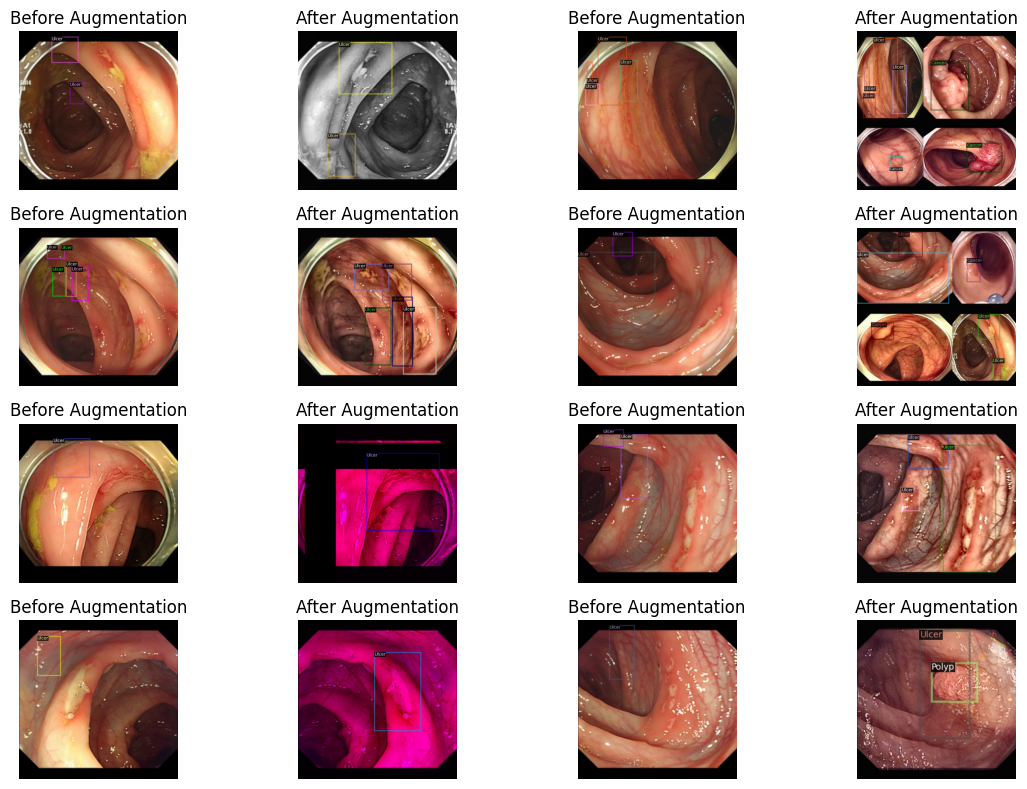

In [15]:
import detectron2
from detectron2.utils.visualizer import Visualizer, ColorMode

mapper = AlbumentationsMapper(is_train=True)

plt.figure(figsize=(12,8))

for i in range(8):
    plt.subplot(4,4,2*i+1)
    plt.title('Before Augmentation')
    d = dataset_dicts[i]
    img = Image.open(d['file_name'])
    img = np.array(img)
    img = cv2.resize(img, tuple(CFG.img_size))
    visualizer = Visualizer(img, metadata=colonoscopy_metadata, scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.axis('off')
    
    plt.subplot(4,4, 2*i+2)
    plt.title('After Augmentation')
    mapped_d = mapper(d)
    img_arr = mapped_d['image'].cpu().permute(1,2,0).numpy()
    # img_arr[:,:,::-1] # BGR -> RGB
    # VitModel's Input Format: RGB
    visualizer = Visualizer(img_arr, metadata=colonoscopy_metadata, scale=1.0)
    target_fields = mapped_d['instances'].get_fields()
    labels = [colonoscopy_metadata.thing_classes[i] for i in target_fields['gt_classes']]

    out = visualizer.overlay_instances(
        labels = labels,
        boxes = target_fields.get('gt_boxes',None),
        masks = target_fields.get('gt_masks',None),
        keypoints = target_fields.get('gt_keypoints', None)
    )
     
    plt.imshow(out.get_image())
    plt.axis('off')

    del out, visualizer, labels
    
plt.tight_layout()
plt.show()

del mapper; clean_memory()

## 5. Lazyconfing Train Net
___

1) DefaultTrainer is limited to yacs configs. So, for using LazyConfig file, we should use `SimpleTrainer` or `AMPTrainer`

2) LazyConfig is an alternative, non-intrusive config system that can be used with detectron2 or potentially any other complex projects. 

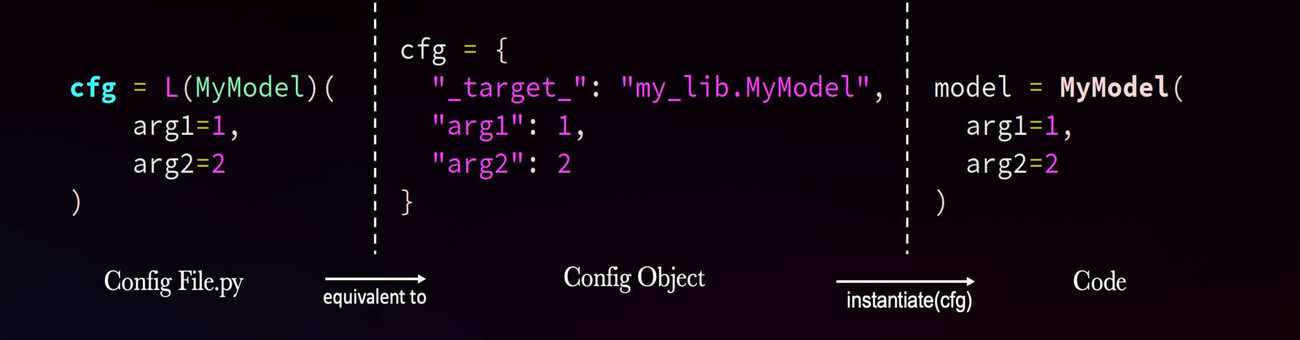
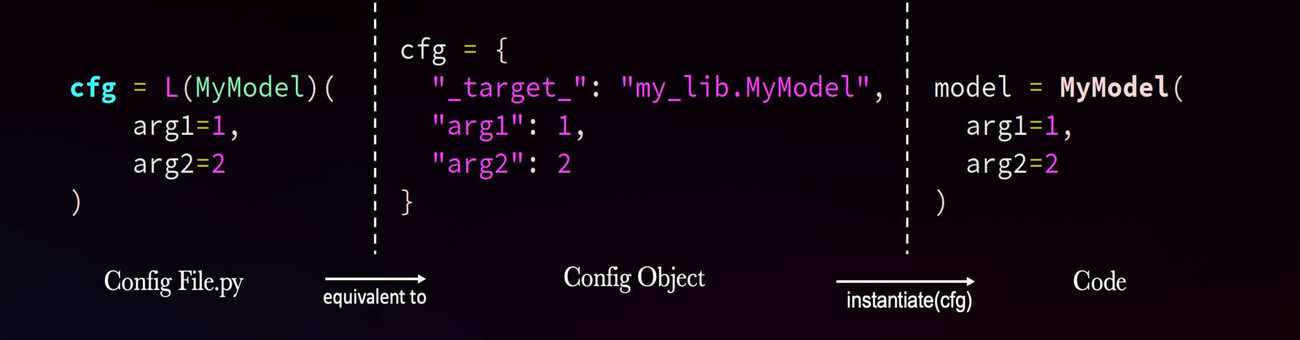

In [16]:
import logging
from functools import partial
from fvcore.common.param_scheduler import MultiStepParamScheduler, CosineParamScheduler

from omegaconf import OmegaConf

from detectron2 import model_zoo 
from detectron2.config import get_cfg, LazyConfig, instantiate
from detectron2.config import LazyCall as L

from detectron2.data import (
    build_detection_train_loader, 
    build_detection_test_loader,
    DatasetMapper,
    get_detection_dataset_dicts)

from detectron2.evaluation import (
     COCOEvaluator,
     inference_on_dataset, 
     print_csv_format)

from detectron2.engine import (
     create_ddp_model,
     AMPTrainer, SimpleTrainer,
     default_argument_parser, default_setup, default_writers,
     hooks, launch ## DDP 
)

from detectron2.solver import WarmupParamScheduler
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import MViT

from detectron2.utils import comm
from detectron2.utils.logger import setup_logger

setup_logger()

<_Logger detectron2 (DEBUG)>

#### Setting LazyConfig File

In [17]:
def setup():
    """DataLoader LazyConfig"""
    dataloader = OmegaConf.create()

    dataloader.train = L(build_detection_train_loader)(
        dataset = L(get_detection_dataset_dicts)(names='colonoscopy_train'),
        mapper = L(AlbumentationsMapper)(is_train=True),
        total_batch_size = CFG.ims_per_batch,
        num_workers = CFG.num_workers
    )

    """Train LazyConfig"""
    train = model_zoo.get_config("common/train.py").train
    train.amp.enabled = True 
    train.ddp.fp16_compression = True
    train.init_checkpoint = (
    "detectron2://ImageNetPretrained/mvitv2/MViTv2_T_in1k.pyth"
    )
    train.output_dir = CFG.output_dir
    train.max_iter = CFG.max_iter
    train.eval_period = CFG.eval_period
    train.checkpointer.period = CFG.eval_period
    train.log_period = CFG.log_period
    train.device = CFG.device

    """Scheduler LazyConfig"""
    lr_multiplier = L(WarmupParamScheduler)(
    scheduler=L(CosineParamScheduler)( 
        start_value = 1, 
        end_value = CFG.base_lr_end / CFG.base_lr),
    warmup_length=0,
    warmup_factor=0,
    warmup_method='linear'
    )

    """Optimizer LazyConfig"""
    optimizer = model_zoo.get_config("common/optim.py").AdamW ## or SGD
    optimizer.params.overrides = {
    "pos_embed": {"weight_decay": 0.0},
    "rel_pos_h": {"weight_decay": 0.0},
    "rel_pos_w": {"weight_decay": 0.0},
     } 
    
    optimizer.lr = CFG.base_lr
        
    optimizer.weight_decay = CFG.weight_decay

    """Model LazyConfig"""
    model = model_zoo.get_config("common/models/mask_rcnn_fpn.py").model
    model.input_format = CFG.input_format

    model.backbone.bottom_up = L(MViT)(
    embed_dim=96,
    depth=10,
    num_heads=1,
    last_block_indexes=(0, 2, 7, 9),
    residual_pooling=True,
    drop_path_rate=0.2,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),
    out_features=("scale2", "scale3", "scale4", "scale5"),
    )
    model.backbone.in_features = "${.bottom_up.out_features}"

    #### Model RPN 
    model.proposal_generator.in_features = ['p2','p3','p4','p5','p6']
    model.proposal_generator.anchor_generator.sizes = [[32], [64], [128], [256], [512]]
    model.proposal_generator.anchor_generator.aspect_ratios = [0.5, 1.0, 2.0]
    model.proposal_generator.anchor_generator.offset = 0.5
    model.proposal_generator.anchor_matcher.thresholds = [0.3, 0.7]
    model.proposal_generator.batch_size_per_image = 256
    model.proposal_generator.pre_nms_topk = [2000, 1000]
    model.proposal_generator.post_nms_topk = [1000, 1000]
    
    #### Model ROI
    model.roi_heads.num_classes = len(thing_classes)
    model.roi_heads.batch_size_per_image = 512
    model.roi_heads.box_in_features = ['p2','p3','p4','p5']
    model.roi_heads.box_pooler.output_size = 7
    model.roi_heads.box_pooler.pooler_type = 'ROIAlignV2'
    model.roi_heads.proposal_matcher.thresholds = [0.5]
    model.roi_heads.box_predictor.test_score_thresh = 0.0

    cfg = OmegaConf.create()
    cfg.model = model
    cfg.dataloader = dataloader
    cfg.train = train
    cfg.optimizer = optimizer
    cfg.lr_multiplier = lr_multiplier

    """Mask-RCNN -> Faster-RCNN"""
    del cfg.model.roi_heads.mask_in_features
    del cfg.model.roi_heads.mask_pooler
    del cfg.model.roi_heads.mask_head 

    return cfg

#### train_net.py

In [18]:
def do_train(resume, cfg):
    model = instantiate(cfg.model)
    logger = logging.getLogger('detectron2')
    logger.info("Model:\n{}".format(model))
    model.to(cfg.train.device)

    cfg.optimizer.params.model = model
    optim = instantiate(cfg.optimizer)

    train_loader = instantiate(cfg.dataloader.train)

    model = create_ddp_model(model, **cfg.train.ddp)
    trainer = (AMPTrainer if cfg.train.amp.enabled else SimpleTrainer)(model, train_loader, optim)

    checkpointer = DetectionCheckpointer(
        model, cfg.train.output_dir, trainer=trainer
    )

    ## including timing 
    ## including checkpointing
    ## including lr scheduling
    ## including writing events
    trainer.register_hooks(
        [
            hooks.IterationTimer(),
            hooks.LRScheduler(scheduler=instantiate(cfg.lr_multiplier)),
            hooks.PeriodicCheckpointer(checkpointer, **cfg.train.checkpointer)
            if comm.is_main_process() else None,
            hooks.PeriodicWriter(
                default_writers(cfg.train.output_dir, cfg.train.max_iter),
                period = cfg.train.log_period,
            )
            if comm.is_main_process() else None,
        ]
    )

    checkpointer.resume_or_load(cfg.train.init_checkpoint, resume=resume)
    if resume and checkpointer.has_checkpoint():
        start_iter = trainer.iter + 1
    else:
        start_iter = 0
    trainer.train(start_iter, cfg.train.max_iter)

#### save lazy config file

In [19]:
config_file = LazyConfig.to_py(setup())

with open(f'{CFG.output_dir}/mvit_config.py', 'w') as f:
    f.write(config_file)

In [20]:
SHOW = True

if SHOW:
    with open(f'{CFG.output_dir}/mvit_config.py', 'r') as f:
        print(f.read())

cfg.dataloader.train=detectron2.data.build_detection_train_loader(dataset=detectron2.data.get_detection_dataset_dicts(names='colonoscopy_train'), mapper=__main__.AlbumentationsMapper(is_train=True), num_workers=4, total_batch_size=16)
cfg.lr_multiplier=detectron2.solver.WarmupParamScheduler(scheduler=fvcore.common.param_scheduler.CosineParamScheduler(end_value=1e-09, start_value=1), warmup_factor=0, warmup_length=0, warmup_method='linear')
cfg.model=detectron2.modeling.GeneralizedRCNN(backbone=detectron2.modeling.FPN(bottom_up=detectron2.modeling.MViT(depth=10, drop_path_rate=0.2, embed_dim=96, last_block_indexes=[0,2,7,9], norm_layer=functools.partial(<class 'torch.nn.modules.normalization.LayerNorm'>, eps=1e-06), num_heads=1, out_features=['scale2','scale3','scale4','scale5'], residual_pooling=True), in_features=['scale2','scale3','scale4','scale5'], out_channels=256, top_block=detectron2.modeling.backbone.fpn.LastLevelMaxPool()), input_format='RGB', pixel_mean=[103.53,116.28,123.675

## 6. Training MultiScale VisionTransformer Detection Model
___

In [21]:
do_train(resume=False, cfg=setup())

[03/03 04:42:59 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): MViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      )
      (blocks): ModuleList(
        (0): MultiScaleBlock(
          (norm1): LayerNorm((96,), eps=1e-06, element

MViTv2_T_in1k.pyth: 290MB [00:01, 186MB/s]                           


[03/03 04:43:01 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up - Total num: 54
[03/03 04:43:02 d2.engine.train_loop]: Starting training from iteration 0
[03/03 04:43:40 d2.utils.events]:  eta: 2:25:56  iter: 19  total_loss: 0.6093  loss_cls: 0.2313  loss_box_reg: 0.08339  loss_rpn_cls: 0.221  loss_rpn_loc: 0.025    time: 1.7640  last_time: 1.7411  data_time: 0.1232  last_data_time: 0.1094   lr: 9.9996e-05  max_mem: 12024M
[03/03 04:44:28 d2.utils.events]:  eta: 2:27:21  iter: 39  total_loss: 0.3823  loss_cls: 0.1573  loss_box_reg: 0.1122  loss_rpn_cls: 0.09221  loss_rpn_loc: 0.01917    time: 1.7896  last_time: 1.8094  data_time: 0.1281  last_data_time: 0.1267   lr: 9.9985e-05  max_mem: 12024M
[03/03 04:45:03 d2.utils.events]:  eta: 2:26:29  iter: 59  total_loss: 0.4781  loss_cls: 0.2013  loss_box_reg: 0.163  loss_rpn_cls: 0.09224  loss_rpn_loc: 0.02277    time: 1.7879  last_time: 1.7820  data_time: 0.1284  last_data_time: 0.1332   lr: 9.996

## 7. Visualize Train Hooks
___

In [22]:
metrics = pd.read_json(os.path.join(CFG.output_dir, 'metrics.json'), orient='records', lines=True)
metrics = metrics.sort_values(by=['iteration'])

print('Shape of Metrics: ',metrics.shape)
metrics.head()

Shape of Metrics:  (250, 18)


,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,fast_rcnn/fg_cls_accuracy,iteration,loss_box_reg,loss_cls,loss_rpn_cls,loss_rpn_loc,lr,rank_data_time,roi_head/num_bg_samples,roi_head/num_fg_samples,rpn/num_neg_anchors,rpn/num_pos_anchors,time,total_loss
0,0.109744,8756.706606,0.973633,1.000000,0.0,19,0.083390,0.231326,0.220969,0.025000,0.0001,0.109744,499.84375,12.15625,246.53125,9.46875,1.758375,0.609282
1,0.106504,8841.739472,0.969849,1.000000,0.0,39,0.112188,0.157325,0.092211,0.019166,0.0001,0.106504,496.56250,15.43750,248.09375,7.90625,1.794292,0.382270
2,0.111202,8789.887624,0.958130,1.000000,0.0,59,0.162999,0.201347,0.092237,0.022766,0.0001,0.111202,490.56250,21.43750,246.65625,9.34375,1.768474,0.478058
3,0.113872,8727.365272,0.952698,1.000000,0.0,79,0.179537,0.209924,0.069541,0.018144,0.0001,0.113872,487.78125,24.21875,247.18750,8.81250,1.761351,0.496322
4,0.113538,8689.411656,0.951538,0.997034,0.0,99,0.188006,0.205761,0.066068,0.019508,0.0001,0.113538,486.93750,25.06250,247.56250,8.43750,1.762820,0.472082


#### Scheduler Graph

Scheduler Type is : CosineParamScheduler
Base Learning Rate is : 0.0001
Last Learning Rate is : 1e-09
Iteration is:  5000


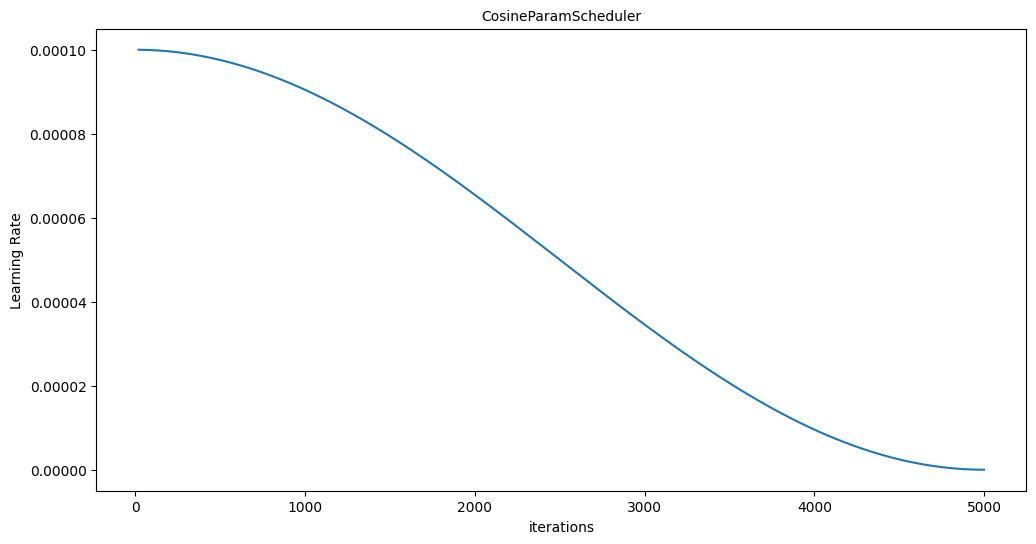

In [23]:
print('Scheduler Type is :', CFG.lr_scheduler_name)
print('Base Learning Rate is :', CFG.base_lr)
print('Last Learning Rate is :', CFG.base_lr_end/CFG.base_lr)
print('Iteration is: ', CFG.max_iter)

plt.style.use('default')
plt.figure(figsize=(12,6))
plt.title(CFG.lr_scheduler_name, size=10)

tmp = metrics[~metrics['lr'].isna()]

plt.plot(tmp['iteration'], tmp['lr'])
plt.xlabel('iterations')
plt.ylabel('Learning Rate')

plt.show()

#### Foreground & Background Fraction in RPN & ROI

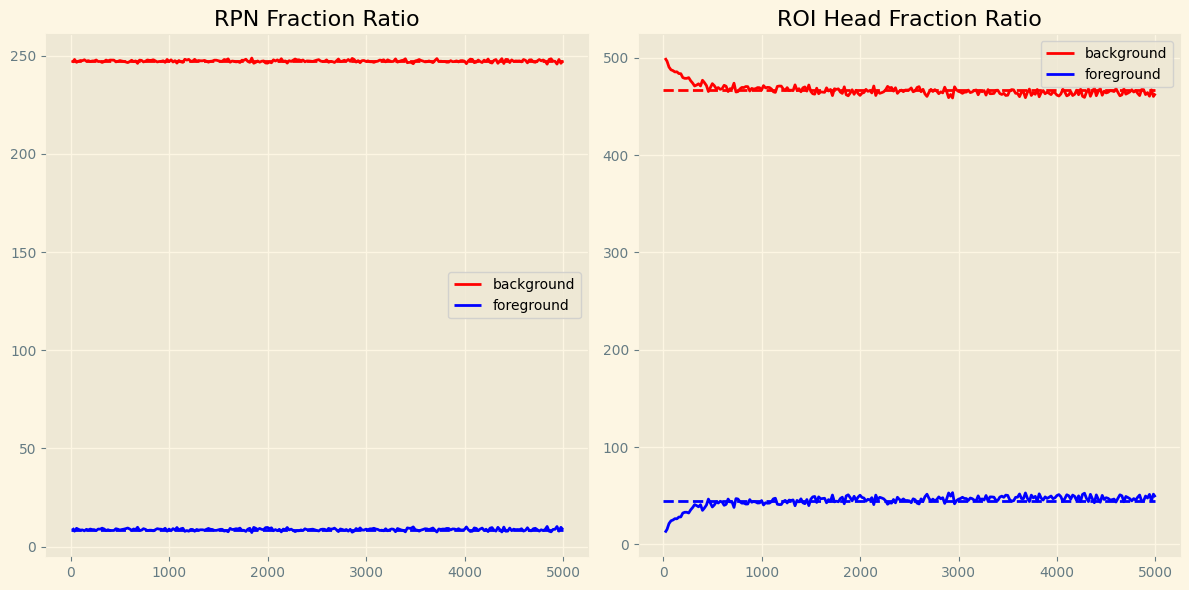

In [24]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title('RPN Fraction Ratio')
tmp = metrics[~metrics['rpn/num_neg_anchors'].isna()]
tmp = tmp[~tmp['rpn/num_pos_anchors'].isna()]
plt.plot(tmp['iteration'], tmp['rpn/num_neg_anchors'], color='red', label='background')
plt.plot([0,tmp['iteration'].max()], [tmp['rpn/num_neg_anchors'].mean(), tmp['rpn/num_neg_anchors'].mean()], '--', color='red')
plt.plot(tmp['iteration'], tmp['rpn/num_pos_anchors'], color='blue', label='foreground')
plt.plot([0,tmp['iteration'].max()], [tmp['rpn/num_pos_anchors'].mean(),tmp['rpn/num_pos_anchors'].mean()], '--', color='blue')

plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.title('ROI Head Fraction Ratio')
tmp = metrics[~metrics['roi_head/num_bg_samples'].isna()]
tmp = tmp[~tmp['roi_head/num_fg_samples'].isna()]
plt.plot(tmp['iteration'], tmp['roi_head/num_bg_samples'], color='red', label='background')
plt.plot([0,tmp['iteration'].max()], [tmp['roi_head/num_bg_samples'].mean(), tmp['roi_head/num_bg_samples'].mean()], '--', color='red')
plt.plot(tmp['iteration'], tmp['roi_head/num_fg_samples'], color='blue', label='foreground')
plt.plot([0,tmp['iteration'].max()], [tmp['roi_head/num_fg_samples'].mean(),tmp['roi_head/num_fg_samples'].mean()], '--', color='blue')

plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

#### Loss: rpn_loc, rpn_cls, box_reg, box_cls

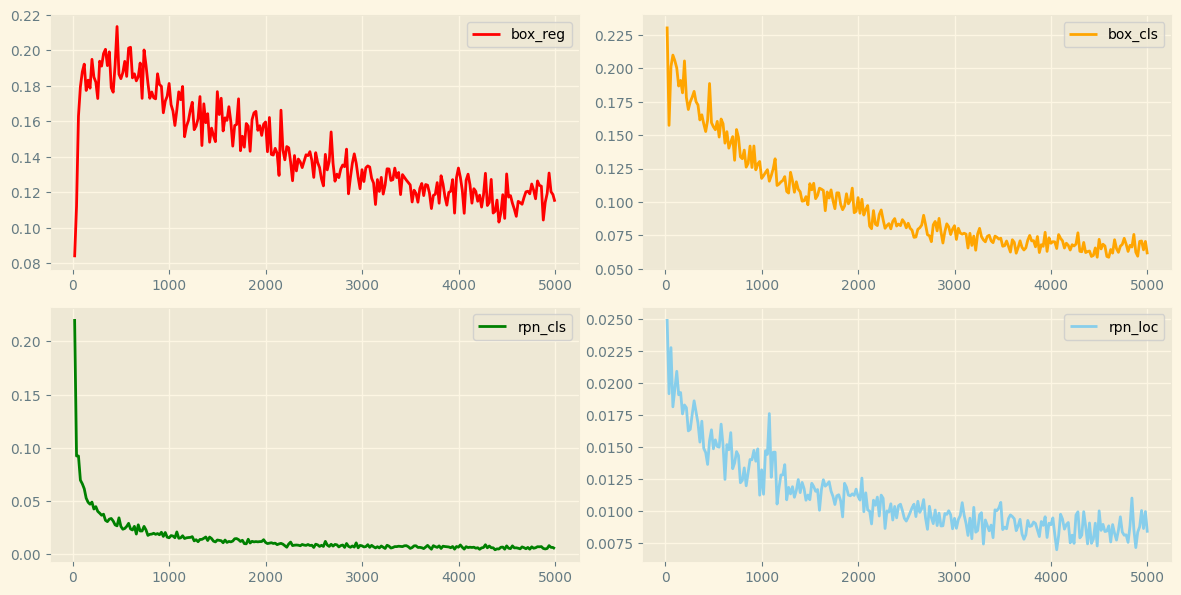

In [25]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
tmp1 = metrics[~metrics['loss_box_reg'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_box_reg'], color='red', label='box_reg')
plt.grid(True); plt.legend()

plt.subplot(2,2,2)
tmp2 = metrics[~metrics['loss_cls'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_cls'], color='orange', label='box_cls')
plt.grid(True); plt.legend()

plt.subplot(2,2,3)
tmp3 = metrics[~metrics['loss_rpn_cls'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_rpn_cls'], color='green', label='rpn_cls')
plt.grid(True); plt.legend()

plt.subplot(2,2,4)
tmp4 = metrics[~metrics['loss_rpn_loc'].isna()]
plt.plot(tmp1['iteration'], tmp1['loss_rpn_loc'], color='skyblue', label='rpn_loc')
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

## 8. Evaluation
___

In [26]:
cfg = setup()

evaluator = COCOEvaluator("colonoscopy_valid", ("bbox",), False, output_dir=os.path.join(CFG.output_dir, 'inference'))

val_loader = build_detection_test_loader(
      dataset = get_detection_dataset_dicts(names='colonoscopy_valid'),
      mapper=AlbumentationsMapper(is_train=False),
      batch_size = CFG.ims_per_batch,
      num_workers = CFG.num_workers,
      )

## Build and Load Model
model = instantiate(cfg.model)
DetectionCheckpointer(model, save_dir=CFG.output_dir).resume_or_load(
            f'{CFG.output_dir}/model_final.pth', resume=False
        )
model.eval()

## Evaluate Metrics
result = inference_on_dataset(model, val_loader, evaluator)

clean_memory(); del model, evaluator, val_loader

[03/03 07:08:47 d2.evaluation.coco_evaluation]: Trying to convert 'colonoscopy_valid' to COCO format ...
[03/03 07:08:47 d2.data.datasets.coco]: Converting annotations of dataset 'colonoscopy_valid' to COCO format ...)
[03/03 07:08:47 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[03/03 07:08:47 d2.data.datasets.coco]: Conversion finished, #images: 320, #annotations: 391
[03/03 07:08:47 d2.data.datasets.coco]: Caching COCO format annotations at 'runs/detect/inference/colonoscopy_valid_coco_format.json' ...
[03/03 07:08:47 d2.data.build]: Removed 0 images with no usable annotations. 320 images left.
[03/03 07:08:47 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Ulcer    | 133          |   Polyp    | 85           |   Cancer   | 173          |
|            |              |     

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 9.1 MB/s eta 0:00:00


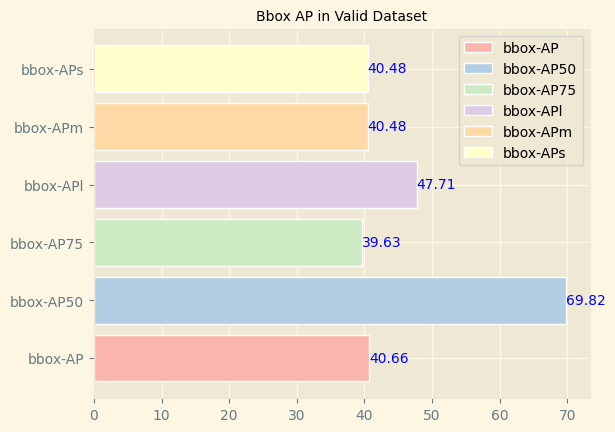

In [27]:
!pip -q install palettable
import palettable.colorbrewer.qualitative as pbq

plt.title('Bbox AP in Valid Dataset', size=10)
ax = plt.barh(y=['bbox-AP', 'bbox-AP50', 'bbox-AP75', 'bbox-APl', 'bbox-APm', 'bbox-APs'],
        width=[result['bbox']['AP'], result['bbox']['AP50'], result['bbox']['AP75'], result['bbox']['APl'],
           result['bbox']['APm'], result['bbox']['APm'],], 
        color=pbq.Pastel1_7.hex_colors, edgecolor='white',
        label=['bbox-AP', 'bbox-AP50', 'bbox-AP75', 'bbox-APl', 'bbox-APm', 'bbox-APs'])

for rect in ax.patches:
    x = rect.get_width()
    y = rect.get_y() + rect.get_height()/2.0
    plt.text(x, y, f'{x:.2f}', ha='left', va='center', size=10, color='blue')

plt.legend()
plt.show()

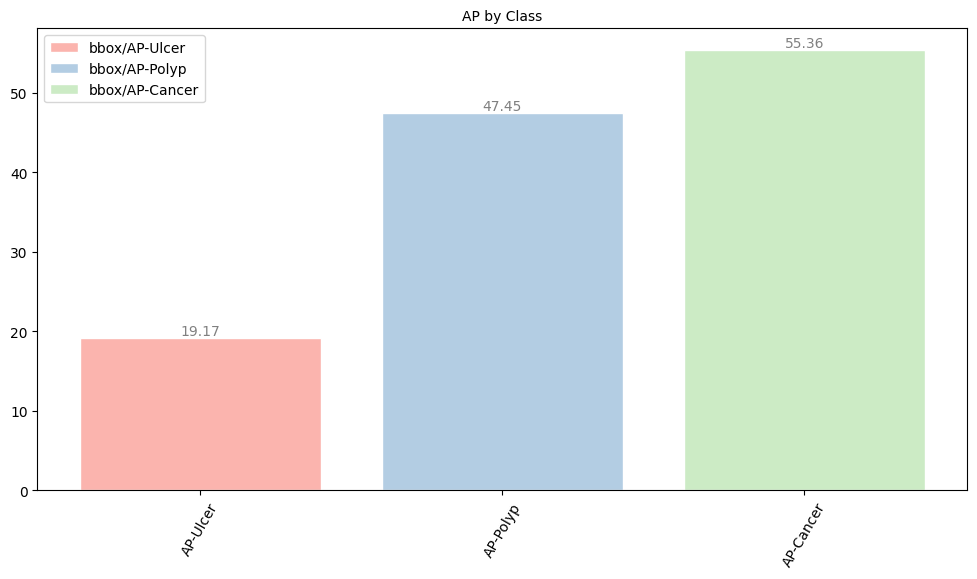

In [28]:
plt.style.use('default')
plt.figure(figsize=(12,6))

plt.title('AP by Class', size=10)
ax = plt.bar(
    x=[f'AP-{col}' for col in thing_classes],
    height=[result['bbox'][f'AP-{col}'] for col in thing_classes],
    color=pbq.Pastel1_7.hex_colors,
    edgecolor='white',
    label=[f'bbox/AP-{col}' for col in thing_classes]
)

# 막대 위에 텍스트 추가
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정


plt.legend()
plt.xticks(rotation=60)
plt.show()